# GLM: implementación en Statsmodels


In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import patsy
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib.pyplot as plt
import itertools

%matplotlib inline

sns.set_style("white")

# Funciones de enlace (link)

Recuerde que un modelo de regresión generalizada esta dado por:

$$y = g(\mathbf{X} \beta) + \epsilon$$

En los modelos *lineales* la función de enlace $g()$ es la identidad, es decir que, no cambia $\mathbf{X} \beta$ en absoluto, y se supone que el ruido $\epsilon$ es gaussiano.

Pero para muchas variables de respuesta, las predicciones lineales no tienen mucho sentido. 

Considere uno el dataset de "g-forces" (de [aquí] (http://www.statsci.org/data/general/gforces.html)).  Con la siguiente descripción:

*Los pilotos militares a veces se desmayan cuando sus cerebros se ven privados de oxígeno debido a las fuerzas G durante maniobras violentas.*

*Glaister y Miller (1990) produjeron síntomas similares al exponer la parte inferior del cuerpo de los voluntarios a una presión de aire negativa, lo que también redujo el oxígeno al cerebro. Los datos enumeran las edades de los sujetos y si mostraron signos relacionados con la pérdida de conocimiento sincopal (palidez, sudoración, latidos cardíacos lentos, pérdida del conocimiento) durante un período de 18 minutos.*

De modo que Glaister y Miller (1990) querían saber si la propensión a la pérdida de conocimiento estaba relacionada con la edad del sujeto. Probaron esto en 8 personas. Importamos los datos:

In [2]:
gf = pd.read_csv('gforces.txt', sep='\t')
# coloca las columnas en minusculas:
gf.columns = [c.lower() for c in gf.columns]
gf

,subject,age,signs
0,JW,39,0
1,JM,42,1
2,DT,20,0
3,LK,37,1
4,JK,20,1
5,MK,21,0
6,FP,41,1
7,DG,52,1


Tenga en cuenta que la variable de respuesta que estamos tratando de predecir (`signs`) toma *solo* uno de dos valores posibles: el sujeto mostró signos de pérdida de conocimiento (y = 1) o no (y = 0) .

¿Qué sucede si ajustamos una regresión lineal ordinaria (error de Gauss) a estos datos?

In [3]:
fit_lm = smf.glm('signs ~ age', gf).fit()
print(fit_lm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  signs   No. Observations:                    8
Model:                            GLM   Df Residuals:                        6
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                         0.23433
Method:                          IRLS   Log-Likelihood:                -4.3968
Date:                Thu, 01 Oct 2020   Deviance:                       1.4060
Time:                        13:23:02   Pearson chi2:                     1.41
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0998      0.540     -0.185      0.8

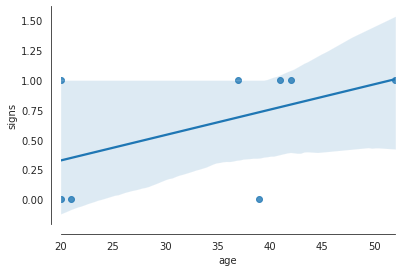

In [4]:
# Miremos las predicciones del modelo
sns.regplot('age', 'signs', gf)
sns.despine(offset=10);

Observe que los datos son solo "0" o "1", pero nuestro modelo puede predecir valores fuera de este rango. Además, éste modelo espera que los errores sean gaussianos, y claramente no lo serán. Por tanto, este modelo lineal no es apropiado para estos datos.

En cambio, lo que queremos es cambiar la función de enlace $f()$ de la identidad (es decir, nuestra predicción es solo $\mathbf{X} \beta$ con errores gaussianos) a algo más apropiado para los datos que tenemos. Vamos a *transformar* el predictor lineal en un rango más apropiado, cambiando la función de enlace.

Nuestro predictor lineal teóricamente puede oscilar entre "-inf" y "+ inf". Queremos algo que mapee este rango en el rango 0-1. Hay varias opciones, pero la más común es la función logística:

$y = \frac{1}{1 + e^{-x}}$

Grafiquemos lo que hace esto:

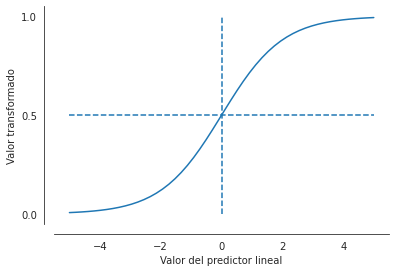

In [5]:
def logit(x): 
    return(1. / (1. + np.exp(-x)))

x = np.linspace(-5, 5)  # este es el predictor lineal (producto punto entre X y beta)
y = logit(x)
plt.plot(x, y)
sns.despine(offset=10)
plt.vlines(0, 0, 1, linestyles='--')
plt.hlines(0.5, -5, 5, linestyles='--')
plt.yticks([0, 0.5, 1])
plt.xlabel('Valor del predictor lineal')
plt.ylabel('Valor transformado');

Observe que a medida que el predictor lineal se acerca al infinito negativo, su valor transformado se acerca a cero, pero nunca baja. De manera similar, cuando el predictor lineal se acerca al infinito positivo, su valor se acerca a uno, pero nunca por encima:

In [6]:
logit(-np.inf)

0.0

In [7]:
logit(np.inf)

1.0

La transformación `logit` nos permite mapear nuestro predictor lineal en un rango acotado. Tenga en cuenta también que cuando el predictor lineal es cero, el logit es 0,5.

¿Cómo podemos usar ahora este valor transformado para predecir respuestas dicotómicas?

### Distribución binomial

Dado que la variable de respuesta es dicotómica ("muestra signos" o "no muestra signos"), una distribución de probabilidad apropiada para describir los datos es la distribución binomial. Así como la distribución normal devuelve una densidad de probabilidad sobre una dimensión continua dada una media y una desviación estándar, la distribución binomial da una función de probabilidad sobre una dimensión discreta (número de "éxitos"), dado un número de "ensayos" y una probabilidad de éxito, $p$ (tenga en cuenta que como $p$ es una probabilidad, puede tener cualquier valor de 0 a 1).

El ejemplo más común utilizado para demostrar la distribución binomial es el lanzamiento de una moneda. Imagina que tenemos una moneda justa ($p = 0.5$) y la lanzamos 50 veces. ¿Cuántas cabezas ("éxitos") esperaríamos? La distribución binomial nos lo puede decir.

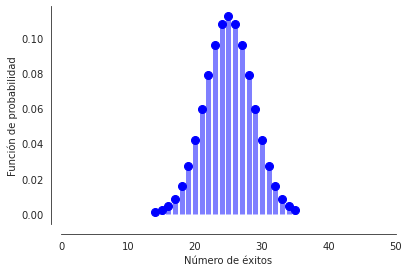

In [8]:
n, p = 50, 0.5
fig, ax = plt.subplots(1, 1)
x = np.arange(sp.stats.distributions.binom.ppf(0.001, n, p), 
              sp.stats.distributions.binom.ppf(0.999, n, p))
ax.plot(x, sp.stats.distributions.binom.pmf(x, n, p), 'bo', ms=8, label='binom pmf')
ax.vlines(x, 0, sp.stats.distributions.binom.pmf(x, n, p), colors='b', lw=5, alpha=0.5)
sns.despine(offset=10);
plt.xlabel('Número de éxitos')
plt.xlim(0, 50)
plt.ylabel('Función de probabilidad');

Ahora imagina que tenemos una moneda con truco, que sale cara el 90% de las veces. ¿Cuántas cabezas esperamos ahora?

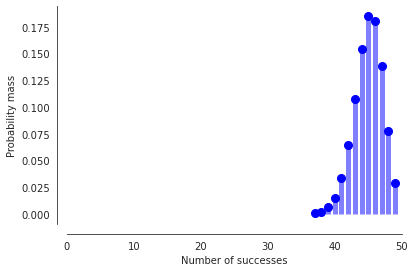

In [9]:
n, p = 50, 0.9
fig, ax = plt.subplots(1, 1)
x = np.arange(sp.stats.distributions.binom.ppf(0.001, n, p), 
              sp.stats.distributions.binom.ppf(0.999, n, p))
ax.plot(x, sp.stats.distributions.binom.pmf(x, n, p), 'bo', ms=8, label='binom pmf')
ax.vlines(x, 0, sp.stats.distributions.binom.pmf(x, n, p), colors='b', lw=5, alpha=0.5)
sns.despine(offset=10);
plt.xlabel('Number of successes')
plt.xlim(0, 50)
plt.ylabel('Probability mass');

Entonces puede ver que al cambiar $p$ cambia el número de éxitos que esperamos de un número dado de intentos (de manera equivalente, la posibilidad de éxito en cualquier intento).

Ahora, suponiendo que nuestra distribución de respuesta está distribuida binomialmente, podemos estimar la probabilidad esperada de mostrar signos de pérdida de conocimiento en función de la edad. Para hacer esto, usamos el predictor lineal transformado con *logit* como nuestra estimación de $p$ en la distribución binomial.

Podemos usar la función `glm` de statsmodel para encontrar los pesos de regresión que maximizan la probabilidad de los datos observados, asumiendo que los datos provienen de una distribución binomial:

In [10]:
fit = smf.glm( 'signs ~ age', 
               data=gf, 
               family=sm.families.Binomial(link=sm.families.links.logit()) ).fit()
# No tenemos que especificar el enlace logit anterior, ya que es el predeterminado
# para la distribución binomial.

print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  signs   No. Observations:                    8
Model:                            GLM   Df Residuals:                        6
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4.2173
Date:                Thu, 01 Oct 2020   Deviance:                       8.4345
Time:                        13:23:03   Pearson chi2:                     7.42
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9209      2.647     -1.104      0.2

Obtenemos una tabla de resumen con los coeficientes de regresión como se hizo antes. Observe que algunas cosas han cambiado: en particular, vea que la `Model Family` ahora es" Binomial ", y la `Link Function` es el logit. Esta es la misma **regresión logística**, porque utiliza la función de enlace logit.

¿Cómo se comparan los coeficientes de regresión anteriores con el modelo lineal gaussiano que ajustamos antes?

In [11]:
print(fit_lm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  signs   No. Observations:                    8
Model:                            GLM   Df Residuals:                        6
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                         0.23433
Method:                          IRLS   Log-Likelihood:                -4.3968
Date:                Thu, 01 Oct 2020   Deviance:                       1.4060
Time:                        13:23:03   Pearson chi2:                     1.41
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0998      0.540     -0.185      0.8

Observe que los coeficientes de regresión son números totalmente diferentes. Sin embargo, nuestra *matriz de diseño* $\mathbf{X}$ no cambió: sigue siendo una columna de unos y una columna de `age`. La razón por la que los coeficientes son diferentes es porque en la regresión logística, los pesos $\beta$ pasan a través de la función de enlace para dar una predicción para la variable respuesta.

Repasemos lo que significan los coeficientes de regresión en la regresión logística.

El `Intercept` es el valor del *predictor lineal* (nota: ¡no la respuesta!) Cuando `age` = 0. En este caso, no podemos observar una edad de cero, por lo que el intercepto no es muy significativo

*Nota: Para hacer que la intersección sea más interpretable, podríamos centrar la variable `edad` restando su media; esto haría que la intersección sea igual al valor del predictor lineal cuando la edad está en su media en los datos. Podríamos hacer esto dentro de la fórmula de Patsy escribiendo `signs ~ center(age)`. Evitaremos hacer esto aquí por simplicidad.*

El coeficiente de `age` nos dice el cambio en el *predictor lineal* para un aumento en la edad de un año.

Con el fin de averiguar qué significan para el valor de la *respuesta*, debemos pasarlos a través de la función logit. Como ejemplo, consideremos la predicción de la probabilidad de que una persona de 28 años muestre signos de perder el conocimiento.

In [12]:
age = 28
linear_predictor = fit.params[0] + fit.params[1]*age
linear_predictor

0.03850819277904938

In [13]:
pred = logit(linear_predictor)
pred

0.5096258587239798

Entonces, nuestra predicción para un joven de 28 años es que tendría un 51% de probabilidad de perder el conocimiento. También podemos calcular esto usando el método `predict` del objeto de ajuste. Hagamos eso para una persona de 65 años:

In [14]:
fit.predict(exog={'age':65})

0    0.981092
dtype: float64

Nuestro modelo predice que una persona de 65 años tendría un 98,1% de posibilidades de perder el conocimiento. ¿Qué pasaría si intentáramos hacer predicciones similares a partir del modelo lineal (inapropiado)?

In [15]:
fit_lm.predict(exog={'age': 65})

0    1.285853
dtype: float64

El modelo lineal predice un valor de 1,28 para una persona de 65 años, lo que no tiene sentido.

## Graficando las predicciones de los modelos

Grafiquemos las predicciones de nuestro modelo para detectar la probabilidad de pérdida de conocimiento vs los datos.

In [16]:
# define la funcion expand grid:
def expand_grid(data_dict):
    """ A port of R's expand.grid function for use with Pandas dataframes."""
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

# Construye una nueva matriz con el grid expandido:
preds = expand_grid({'age': np.linspace(10, 80, num=100)})  # Coloca una linea en los ejes para graficar una curva suave.
preds['yhat'] = fit.predict(preds)

# se anyade a los datos:
merged = gf.append(preds)
merged.tail()

,subject,age,signs,yhat
95,NaN,77.171717,NaN,0.994704
96,NaN,77.878788,NaN,0.995084
97,NaN,78.585859,NaN,0.995436
98,NaN,79.292929,NaN,0.995763
99,NaN,80.000000,NaN,0.996067


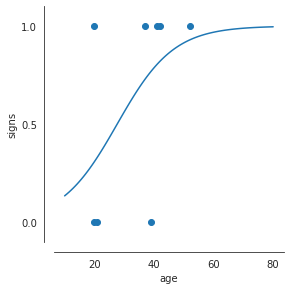

In [17]:
g = sns.FacetGrid(merged, height=4)
g.map(plt.plot, 'age', 'yhat')  # plot model predictions
g.map(plt.scatter, 'age', 'signs')
sns.despine(offset=10);
plt.ylim([-.1, 1.1])
plt.yticks([0, 0.5, 1]);

## Regresión logística con predictores categóricos y continuos

Podemos extender la matriz de diseño para incluir cualquier combinación de predictores continuos y categóricos, pero usando la función de enlace logística para predecir datos 0-1.

Para demostrar esto, usaremos un conjunto de datos de un experimento psicofísico [(Wallis & Bex, 2012)] (http://www.journalofvision.org/content/12/7/6). En este experimento, tres observadores detectaron la ubicación de un objetivo incrustado en una imagen natural en un paradigma de elección forzada. El objetivo (un parche circular de textura) podría aparecer arriba, a la derecha, abajo o a la izquierda del punto de fijación del observador. Los estímulos se parecían un poco a esto:

<img src='stimulus.png'>

La imagen de arriba contiene 12 parches de textura (tres en cada meridiano cardinal en relación con el punto de fijación). Tenga en cuenta que en el experimento real, solo se mostró un parche en una de las cuatro posibles ubicaciones de destino.

Después de cada prueba, el observador respondió con uno de los cuatro botones. Esta es una tarea de elección forzada de cuatro alternativas (4AFC): si el observador no puede ver el objetivo en absoluto, el rendimiento promedio debe ser correcto en un 25%.

Variamos, entre otras cosas, el tamaño del parche y la excentricidad (distancia desde la fijación).

In [18]:
nat_ims = pd.read_csv('psychophysics.txt', sep='\t')
# columns to lowercase:
nat_ims.columns = [c.lower() for c in nat_ims.columns]
nat_ims.head()

,observer,trialnum,blocknum,eccent,patchsize,correct,targetloc,responseloc,imageori
0,TW,1.0,1.0,2.0,-0.391207,1.0,u,u,0CW
1,TW,2.0,1.0,2.0,-0.391207,1.0,d,d,270CW
2,TW,3.0,1.0,2.0,-0.505150,0.0,d,r,180CW
3,TW,4.0,1.0,2.0,-0.505150,1.0,l,l,270CW
4,TW,5.0,1.0,2.0,-0.505150,1.0,u,u,0CW


Cada fila del conjunto de datos corresponde a un ensayo. Nos dan las variables de `observer`, los números de ensayo y de bloque (`trialnum` y `blocknum`), la excentricidad `eccent`, el tamaño del parche de registro (log10 píxeles) `parchsize`, la ubicación del objetivo (en relación con la fijación) `targetloc`, la ubicación de la respuesta (en relación con la fijación) `responseloc` y la orientación de la imagen en relación con su orientación verídica `imageori`.

Finalmente, la columna `correct` nos dice si el observador obtuvo la prueba correcta ("1") o incorrecta ("0").

¿Cuántos ensayos hizo cada observador?

In [19]:
nat_ims.groupby(['observer']).size()

observer
N1    17200
PB    16918
TW    16932
dtype: int64

Entonces, cada observador hizo alrededor de 17000 ensayos. Debido a que ~ 50.000 observaciones es bastante, graficar lleva un tiempo. Por esta razón, primero tomaremos una submuestra aleatoria de los datos.

In [20]:
np.random.seed(12345)  # seed rng so these results are reproducible.
rows = np.random.choice(nat_ims.index, size=5000, replace=False)
dat = nat_ims.iloc[rows].copy() 
dat.groupby(['observer', 'eccent']).size()

observer  eccent
N1        2.0       558
          4.0       597
          8.0       510
PB        2.0       527
          4.0       547
          8.0       571
TW        2.0       538
          4.0       570
          8.0       582
dtype: int64

¿Cómo podemos predecir el rendimiento en todas las pruebas? Este es otro ejemplo de un conjunto de datos binomial, que podemos modelar mediante regresión logística.

Podemos graficar algunos de los datos y ajustar modelos en un solo paso usando Seaborn:

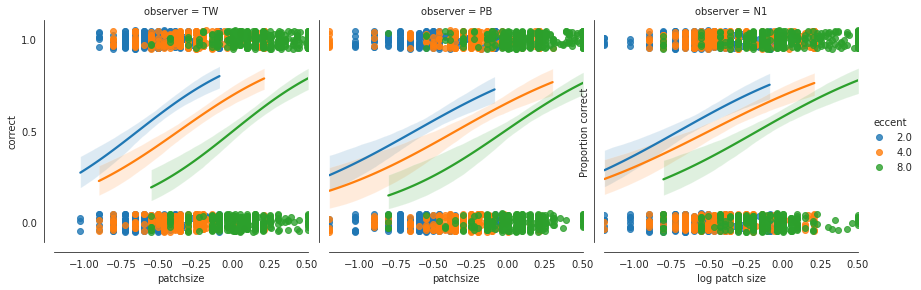

CPU times: user 16.5 s, sys: 151 ms, total: 16.6 s
Wall time: 16.5 s


In [21]:
%%time
sns.lmplot('patchsize', 'correct', data=dat,
           hue='eccent',
           col='observer',
           logistic=True,
           y_jitter=.05,
           height=4)
sns.despine(offset=10)
g.fig.subplots_adjust(wspace=0.5)
plt.xlabel('log patch size')
plt.ylabel('Proportion correct')
plt.yticks([0, 0.5, 1])
plt.show()

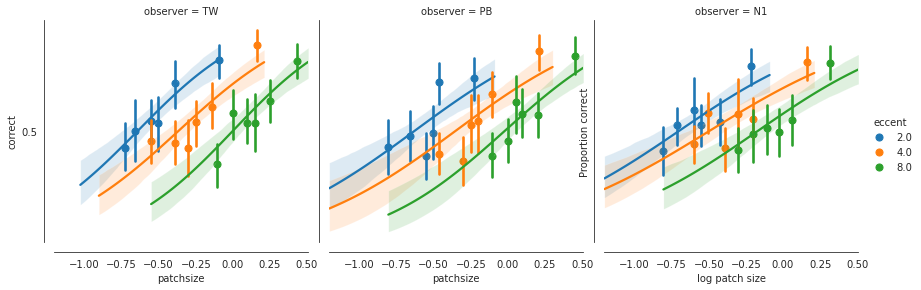

CPU times: user 17.2 s, sys: 144 ms, total: 17.3 s
Wall time: 17.2 s


In [22]:
%%time
# los datos son mas faciles de ver si agrupamos los ensayos a lo largo del eje x: 
sns.lmplot('patchsize', 'correct', data=dat,
           hue='eccent',
           col='observer',
           logistic=True,
           x_bins=6,
           height=4)
sns.despine(offset=10)
g.fig.subplots_adjust(wspace=0.5)
plt.xlabel('log patch size')
plt.ylabel('Proportion correct')
plt.yticks([0, 0.5, 1])
plt.show()

Ahora ajustemos una regresión logística usando Statsmodels que considere la influencia del tamaño del parche y la excentricidad, pero codificaremos la excentricidad como una variable categórica con 3 niveles.

Tenga en cuenta que para simplificar, solo ajustaremos a todos los datos (agrupados entre observadores). Esto podría analizarse como un diseño de medidas repetidas (las condiciones están anidadas dentro de los observadores).

In [23]:
fit = smf.glm('correct ~ patchsize + C(eccent)', 
              data=nat_ims, 
              family=sm.families.Binomial()).fit()
# No especificamos la funcion de enlace de logit, porque esta por defecto.
print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                correct   No. Observations:                51050
Model:                            GLM   Df Residuals:                    51046
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33392.
Date:                Thu, 01 Oct 2020   Deviance:                       66784.
Time:                        13:23:37   Pearson chi2:                 5.10e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.2857      0.025  

¿Qué significan los coeficientes?

La intersección es el valor del predictor lineal cuando el objetivo está a 2 grados de la fijación y el tamaño del parche de registro es cero. En este caso, el modelo predice que el rendimiento será `logit(1.2857)`, aproximadamente un 78% correcto.

Los dos coeficientes para la excentricidad muestran el desplazamiento aplicado al predictor lineal cuando la excentricidad es de 4 u 8 grados, en relación con una excentricidad de 2. Por lo tanto, cuando el tamaño del parche logarítmico es cero, predecimos que el rendimiento a 4 grados será `logit (1.2857 -0,5116) `, aproximadamente un 68% correcto. De manera similar, se esperaría que un parche de tamaño de registro cero presentado a 8 grados de la fijación produzca un 51% correcto.

El parche del mismo tamaño es más difícil de detectar cuanto más lejos de la fijación se presenta.

Finalmente, el coeficiente del `patchsize` muestra el cambio en el predictor lineal para una unidad (es decir, 1 cambio de unidad logarítmica) en el tamaño del parche. A 2 grados, un parche de tamaño de registro 0 produce un 78% correcto (ver arriba); si el parche tenía un tamaño de registro 1, se esperaría que arrojara `logit (1.2857 + 2.0228 * 1)` o un 96% correcto, en promedio.

## Conclusión: modelos binomiales

El GLM se puede utilizar para modelar una variable de respuesta dicotómica asumiendo que la variable se distribuye de acuerdo con una distribución binomial.

Para hacer esto, "aplastamos" el predictor lineal a través de la función `logit`, que le da límites entre 0 y 1. Este procedimiento de aplastamiento y de familia binomial es un ejemplo de cómo cambiar la función de enlace de identidad y el modelo del error. Esto es lo que hace que el GLM sea "generalizado".

Note la forma en que construimos o interpretamos la matriz de diseño no ha cambiado para nuestro modelo.

# Regresión de Poisson

Es común en neurociencia medir la actividad de picos de las neuronas. Los picos a lo largo del tiempo se pueden considerar como "eventos" y, por lo tanto, el número de picos en un intervalo de tiempo como cuenta de eventos.

Los recuentos son discretos y no negativos, por lo que modelar su distribución requiere nuevamente un tipo diferente de GLM. Afortunadamente, podemos lograrlo nuevamente cambiando la función de enlace.

Como ejemplo muy breve, consideramos una neurona grabada de V1 mientras muestra una rejilla con dos orientaciones diferentes en dos contrastes diferentes. ¿Qué tipo de diseño tenemos aquí?

In [24]:
spk = pd.read_csv('neuron2.txt', sep='\t',index_col=False)

In [25]:
spk.head()

,spikes,contrast,orientation
0,3.0,1.0,0.0
1,6.0,1.0,0.0
2,3.0,1.0,0.0
3,3.0,1.0,0.0
4,6.0,1.0,0.0


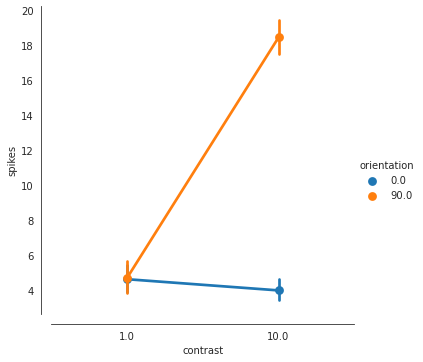

In [26]:
sns.catplot("contrast","spikes","orientation",spk,kind='point')
sns.despine(offset=10);

¿Qué tipo de efectos asumiría cuando ajustamos un GLM con la función de enlace adecuada?

La familia del modelo correcta para los datos de recuento es la familia de Poisson, con la función de enlace de log

$X\beta = \ln(\mu)$

o al revés

$\mu = \exp(X\beta)$

Esto se encarga de dos cosas
- La salida no es negativa
- La varianza de la salida aumenta con la entrada, como en los datos de recuento

In [27]:
fit = smf.glm('spikes ~ contrast * orientation', 
              data=spk, 
              family=sm.families.Poisson(link=sm.families.links.log())).fit()
print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 spikes   No. Observations:                  156
Model:                            GLM   Df Residuals:                      152
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -374.91
Date:                Thu, 01 Oct 2020   Deviance:                       194.83
Time:                        13:23:37   Pearson chi2:                     184.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.5515 

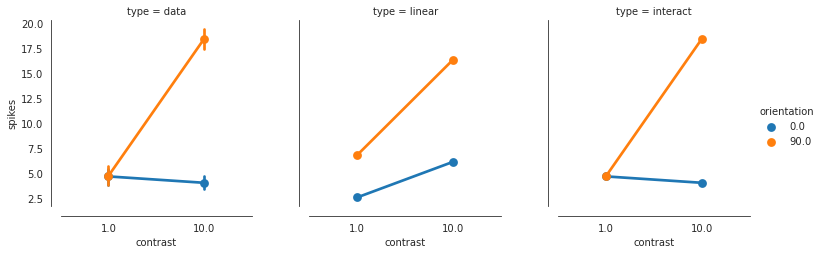

In [28]:
# crea una nueva matriz con el grid expandido
preds = expand_grid({'contrast': [1, 10], 'orientation': [0, 90]})  
preds_2 = preds.copy()

preds['spikes'] = fit.predict(preds)

# tambien se puede ajustar un modelo sin interaccion, para comparar
#fit_2 = smf.glm('spikes ~ contrast * orientation', spk).fit()
fit_2 = smf.glm('spikes ~ contrast + orientation', data=spk, 
              family=sm.families.Poisson(link=sm.families.links.log())).fit()
preds_2['spikes'] = fit_2.predict(preds_2)

# para graficar las predicciones del modelo vs los datos, debemos fusionarlos
merged = pd.concat(dict(data=spk, 
                        linear=preds_2,
                        interact=preds),
                   names=['type']).reset_index()

g = sns.catplot('contrast', 'spikes', 'orientation', 
                   data=merged, 
                   col='type',
                   kind='point',
                   height=3.5)
g.fig.subplots_adjust(wspace=0.3)
sns.despine(offset=10);

Tenga en cuenta que esto es particularmente importante si los recuentos son bajos, porque su no negatividad juega un papel importante.

In [29]:
print(fit_2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 spikes   No. Observations:                  156
Model:                            GLM   Df Residuals:                      153
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -437.65
Date:                Thu, 01 Oct 2020   Deviance:                       320.31
Time:                        13:23:38   Pearson chi2:                     328.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.8332      0.075     11.168      

In [30]:
# Hace una predicción expandida para muchos contrastes, compare con el modelo lineal:
preds_3 = expand_grid({'contrast': np.linspace(0.01, 20), 'orientation': [0, 90]})  
preds_4 = preds_3.copy()

preds_3['yhat'] = fit.predict(preds_3)

fit_lm = smf.glm('spikes ~ contrast + orientation', data=spk).fit()
preds_4['yhat'] = fit_lm.predict(preds_3)

# para graficar las predicciones del modelo vs los datos, debemos fusionarlos
merged = pd.concat(dict(data=spk, 
                        poisson=preds_3,
                        linear=preds_4),
                   names=['type']).reset_index()
merged.tail()

,type,level_1,spikes,contrast,orientation,yhat
351,linear,95,NaN,19.184082,90.0,21.557336
352,linear,96,NaN,19.592041,0.0,14.598469
353,linear,97,NaN,19.592041,90.0,21.854879
354,linear,98,NaN,20.000000,0.0,14.896011
355,linear,99,NaN,20.000000,90.0,22.152422


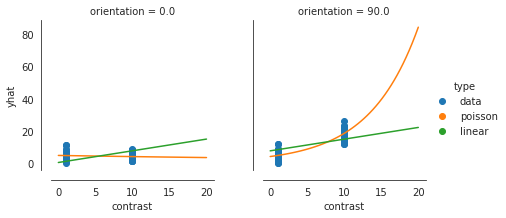

In [31]:
g = sns.FacetGrid(merged,
                  hue='type',
                  col='orientation')
g.map(plt.scatter, 'contrast', 'spikes')
g.map(plt.plot, 'contrast', 'yhat')
g.fig.subplots_adjust(wspace=0.3)
sns.despine(offset=10)
g.add_legend();


Puede ver que los modelos lineal y de Poisson dan predicciones muy diferentes fuera del rango de estos datos. Además, el modelo lineal

- puede predecir tasas negativas
- supone que la varianza es homogénea, pero para las distribuciones de tasas (es decir, Poisson), la varianza se escala con la media.

# Conclusión

El GLM nos permite especificar diferentes distribuciones para la variable de respuesta $y$ y para la función de enlace $g()$. Hemos considerado dos ejemplos del contexto de la ciencia del comportamiento / neuronal: porcentaje de datos correctos (regresión binomial) y datos de picos (regresión de Poisson). La siguiente tabla muestra, para varios tipos de datos de la variable respuesta, el modelo de error y las funciones de enlace más comunes.


Scale type of $y$ | Typical noise distribution of $y$ | Typical link function 
------------------| --------------------------------- | ---------------------
metric (continuous) | normal | identity
dichotomous (0 or 1) | bernoulli | logistic
nominal (unordered categories) | categorical | softmax
ordinal (ordered categories) | categorical | thresholded logistic
count | poisson | log

### Algunas funciones de enlace:

$$
\begin{array}{|l|l|l|l|}
\hline \text { Density } & \text { Link: } \eta=g(\mu) & \text { Default link } & \text { glm(family=...) } \\
\hline \text { Normal } & \eta=\mu & \text { identity } & \text { Gaussian() } \\
\hline \text { Poisson } & \eta=\log (\mu) & \text { logarithm } & \text { Poisson() } \\
\hline \text { Binomial } & \eta=\log [p /(1-p)] & \text { logit } & \text { Binomial() } \\
\hline \text { Gamma } & \eta=1 / \mu & \text { inverse } & \text { Gamma() } \\
\hline \text { Inverse Gaussian } & \eta=1 / \mu^{2} & \text { inverse squared } & \text { InverseGaussian() } \\
\hline
\end{array}
$$

# Ejercicio 1

[1] Esta pregunta debe responderse utilizando el dataset ``Weekly``. Esta información es contiene 1,089 declaraciones semanales durante 21 años, desde el comienzo de 1990 hasta el final de 2010.

Realice una regresión logística con ``Direction`` como respuesta y las cinco variables ``lag`` más ``Volume`` como predictores. Usando `glm` de statmodels, use diferentes funciones de enlace y comente las diferencias. Use la función `summary` (de statmodels) para imprimir los resultados. ¿Que conclusiones puede obtener de cada modelo?


# Ejercicio 2

En este ejercicio trabajaremos con el conjunto da datos de  `gotelli.csv`. Este dataset investiga los determinantes biográficos de la riqueza de especies a escala regional (Gotelli y Everson, 2002). El objetivo principal de este ejercicio es replicar la **regresión de Poisson** de la riqueza de una especie de hormiga contra la latitud, la elevación y el tipo de hábitat en su papel.

(1) Cargue el dataset y grafique una matriz de dispersión, y evalue si hay algún tipo de colinealidad entre las variables.

In [32]:
df = pd.read_csv("gotelli.csv")
df.head()

,Site,Srich,Habitat,Latitude,Elevation
0,TPB,6,Forest,41.97,389
1,HBC,16,Forest,42.00,8
2,CKB,18,Forest,42.03,152
3,SKP,17,Forest,42.05,1
4,CB,9,Forest,42.05,210


(2) Divida el conjunto en un training y test set. A partir de ahora sólo trabaje con el Training set.

#### Evaluando la colinealidad con VIF (Variable Inflantion Factors)

$R^2$ value is determined to find out how well an independent variable is described by the other independent variables. A high value of $R^2$ means that the variable is highly correlated with the other variables. This is captured by the VIF which is denoted below:

$$VIF=\frac{1}{1-R^2}$$

So, the closer the $R^2$ value to 1, the higher the value of VIF and the higher the multicollinearity with the particular independent variable.

Thus, *VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable.*

Also, *VIF score of an independent variable represents how well the variable is explained by other independent variables*.

El valor de $R^2$ se determina para averiguar qué tan bien una variable independiente es descripta por las otras variables independientes. Un valor alto de $R^2$ significa que la variable está altamente correlacionada con las otras variables. Esto es capturado por el VIF que se indica a continuación:

$$VIF=\frac{1}{1-R^2}$$

Entonces, cuanto más cerca esté el valor de $R^2$ a 1, mayor será el valor de VIF y mayor será la multicolinealidad con la variable independiente particular.

Por tanto, *VIF determina la fuerza de la correlación entre las variables independientes. Se predice tomando una variable y haciendo una regresión frente a cualquier otra variable.*

Además, *la puntuación VIF de una variable independiente representa qué tan bien la variable es explicada por otras variables independientes*.

ALgunos tips para saber si como interpretar el VIF son:

- VIF comienza en 1 y no tiene límite superior
- Si el VIF = 1, no hay correlación entre la variable independiente y las otras variables
- Si el VIF superior a 5 o 10 indica una alta multicolinealidad entre esta variable independiente y las demás.

A continuación, se realiza una implementación:

In [33]:
def calc_vif(fit):
    """Calcula el VIF para un modelo fit resultado del ajuste de GLM (o OLS)"""

    cov = fit.cov_params() # extrae la covarianza
    corr = cov / fit.bse / fit.bse # Calcula la correlacion con base en los parametros
    
    vif = pd.Series(np.diag(np.linalg.inv(corr.values[1:, 1:])), index=fit.bse.index[1:])

    return(vif)

(3) Realice una regresión de Poisson, involucrando las variables de habitat, latitude y la elevación y sus interacciones. Determine los VIF para cada variable. Evalue el modelo con alguna métrica sobre el Test set (R2, varianza explicada, RMSE, etc).

(4) Si hay una covariación alta centre las variables (restar la media).

(5) Realice de nuevo el modelo con la regresión de Poisson y evalue la colinealidad con el VIF. Evalue el modelo sobre el Test set.
